## Structured Latent Spaces MNIST

In [1]:
import torch
import argparse
import MNIST_123 
device = "cuda" if torch.cuda.is_available() else "cpu"
args = argparse.Namespace(
    data_path="../data",
    batch_size=256,
    latent_dim=128,
    device=device
)

# Architecture Reasoning

---

## 1. Overview of Our Solution

We designed a contrastive autoencoder using a **lightweight convolutional encoder** trained on **augmented MNIST digit pairs**. The encoder was trained in a **self-supervised manner** using contrastive loss. After training, a small classifier was trained on frozen latent representations.

The core idea was to **learn digit representations** that are invariant to transformations. For this, we followed a SimCLR-inspired setup with strong data augmentation and a projection head that separates contrastive objectives from downstream tasks.

---

## 2. Encoder Architecture

### Structure Breakdown:
- **Conv1 (1 → 32 channels)**  
  - Kernel: 3×3, Stride: 2, Padding: 1  
  - Activation: ReLU  
  - Output size: 14×14

- **Conv2 (32 → 64 channels)**  
  - Kernel: 3×3, Stride: 2, Padding: 1  
  - Activation: ReLU  
  - Output size: 7×7

- **AdaptiveAvgPool2d → Linear → Latent**
  - Downsamples to 1×1 (global embedding)  
  - Fully connected layers: `64 → 256 → 128`  

### Why This Works:
- Compact yet expressive latent space
- Captures key shape and stroke information from digits
- Projection head improves generalization under contrastive loss

---

## 3. Contrastive Training

We use **NT-Xent contrastive loss**:
- Input: two different augmentations of the same image (positive pair)
- Negative pairs: other examples in the batch
- Metric: cosine similarity, scaled with temperature τ = 0.1

### Why Contrastive?
- Enables learning without labels
- Helps group similar digits in latent space
- Encourages representations to be robust to small perturbations

---

## 4. Classifier Design

We freeze the encoder and train a **simple classifier**:
- MLP: `128 → 64 → 10`
- Activation: ReLU
- Regularization: Dropout (0.2)

### Why This Works:
- Enough capacity for 10-digit classification
- Dropout prevents overfitting
- Uses frozen representations, allowing fair evaluation

---

## 5. Data Augmentation

### Applied to MNIST:
- Random resized crop
- Random rotation
- Random affine shift
- Normalization: `mean = 0.1307`, `std = 0.3081`

### Why It Helps:
- Prevents overfitting on small dataset
- Encourages model to learn shape semantics, not pixel locations

---

## 6. Training and Evaluation

| Component        | Choice                         | Reason                                      |
|------------------|--------------------------------|---------------------------------------------|
| Optimizer        | Adam                           | Fast and adaptive learning                  |
| Loss Function    | Contrastive + CrossEntropy     | Contrastive for self-supervised; CE for classification |
| Batch Size       | args.batch_size (user-defined) | Balanced for compute and performance        |
| Epochs           | 20 for AE, 15 for classifier   | Sufficient for convergence                  |
| LR Scheduler     | CosineAnnealingLR              | Helps fine-tune at the end of training      |

---

## 7. Evaluation Protocol

- Validation split: **90% train / 10% val**
- Classifier trained on frozen latent embeddings
- Validation accuracy tracked each epoch
- Best model saved based on validation
- Final accuracy reported on test set

---

## 8. Summary

This MNIST contrastive pipeline shows that even simple convolutional encoders can learn effective representations with the right self-supervised training and augmentations. Our encoder-classifier setup achieved strong test accuracy with a small model size and efficient training.



In [2]:
train_loader, val_loader, test_loader = MNIST_123.load_data(args)
autoencoder = MNIST_123.Autoencoder(latent_dim=args.latent_dim).to(args.device)

## Training Autoencoder

Epoch 1/1 | Train Loss: 3.2984 | Val Loss: 2.5286 | Test Loss: 1.9539


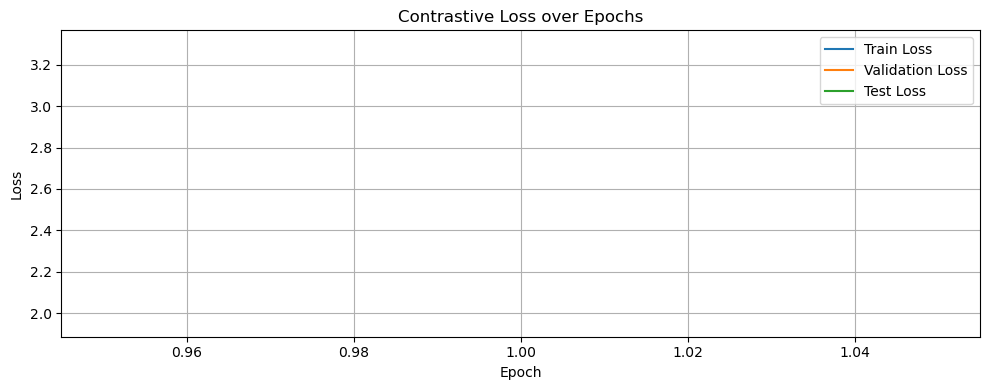

In [3]:
MNIST_123.train_autoencoder(autoencoder, train_loader, val_loader, test_loader,args,epochs=1)

## Training Classifier

Epoch 1/1 | Train Loss: 2.1116 | Train Acc: 33.99% | Val Acc: 44.75% | Test Acc: 45.21%


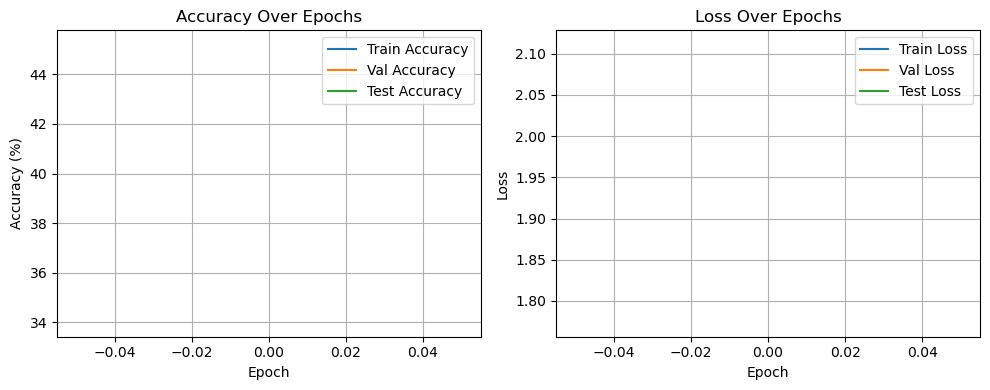

In [4]:
MNIST_123.train_classifier(autoencoder, train_loader, val_loader, test_loader, args,epochs=1)

## t-SNE Analysis of Latent Spaces

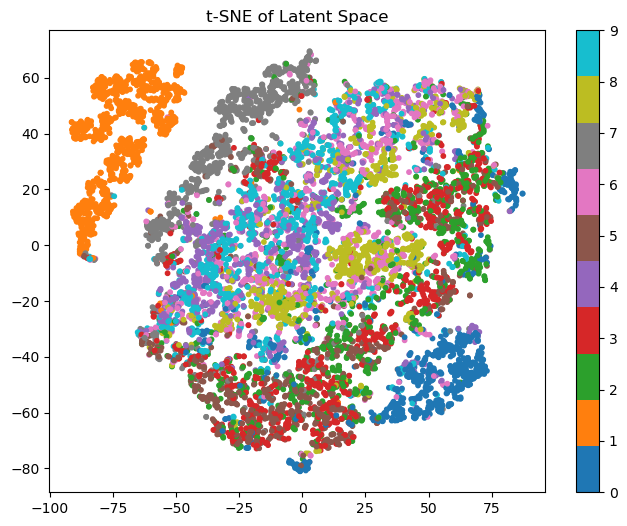

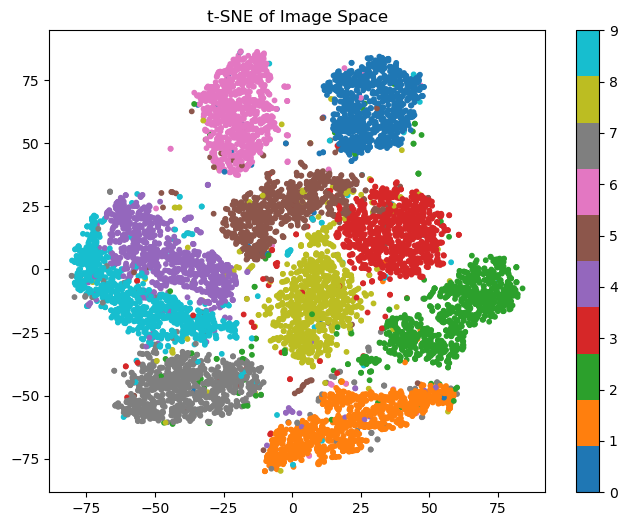

In [5]:
MNIST_123.plot_tsne(autoencoder, test_loader, args.device)